# XGBoost Play Prediction Model Training



In [17]:
import datetime
import json

import xgboost as xgb
from bayes_opt import BayesianOptimization
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

import nflpp

Use cuda for accelerated training if available.

In [18]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

## Process Data

### Load the play-by-play data
The data for this project is provided by the [nfl_data_py](https://github.com/nflverse/nfl_data_py) python library. The dataset covers the NFL seasons from 1999 to 2023, so we'll load all years in that range. A function from this project's `nflpp` module is used to ensure the data is cached and loaded from cache at all times for better peformance.

In [19]:
%%capture
pbp_data = nflpp.load_pbp_data(range(1999, 2024))

### Filter excess data
The vast majority of plays called in an NFL game are either runs or passes. Other types of plays are either forced by game rules (kickoffs) or almost always shown pre-snap by formation (field goals and punts). For these reasons, the play prediction model will focus only on play calls involving a run or pass.

In [20]:
processed_data = pbp_data[pbp_data["play_type"].isin(["run", "pass"])]

print(f"Run/pass filtered shape: {processed_data.shape}")

Run/pass filtered shape: (839562, 390)


The play-by-play data has a large amount of columns that can't be used for this project. The goal is to have the model be used to predict the next play call within the 40 seconds the team has to snap the ball. Many columns, such as `yards_gained`, contain information about the outcome of the play. Others contain data that would not be able to be processed pre-snap, like `wp` (win percentage). Because of this, the data will be filtered down to the most important columns that can be easily gathered pre-snap.

In [21]:
columns = [
    # Target
    "play_type",
    # Features
    "drive",
    "qtr",
    "quarter_seconds_remaining",
    "down",
    "ydstogo",
    "yardline_100",
    "shotgun",
    "no_huddle",
    "score_differential",
    "spread_line",
    "season",
    "posteam",
    # Used to create poscoach
    "home_coach",
    "away_coach",
    "home_team",
    "away_team",
]
processed_data = processed_data[columns]
print(f"Run/pass filtered shape: {processed_data.shape}")

Run/pass filtered shape: (839562, 17)


### Create new column

While the data contains a variable for the team currently in possession of the ball, no such variable exists for the coach. This will create a new column for the possessing team's coach, and then remove the columns used its creation.

In [22]:
processed_data.loc[:, "poscoach"] = processed_data.apply(
    lambda row: row["home_coach"]
    if row["posteam"] == row["home_team"]
    else row["away_coach"],
    axis=1,
)
processed_data = processed_data.drop(
    columns=["home_coach", "away_coach", "home_team", "away_team"]
)
print(f"Post-poscoach shape: {processed_data.shape}")

Post-poscoach shape: (839562, 14)


### Encode descriptive features

XGBoost needs data to be numerical, so the variables that are present in the dataset need to be encoded to integer values.

In [27]:
encodings = {}

for column in ("posteam", "poscoach", "play_type"):
    encoder = LabelEncoder()
    processed_data[column] = encoder.fit_transform(processed_data[column])
    encodings[column] = {
        key: int(value)
        for key, value in zip(encoder.classes_, encoder.transform(encoder.classes_))
    }

encodings_json = json.dumps(encodings)
with open("../data/encodings.json", "w") as f:
    f.write(encodings_json)

### Partition data for training

In order to train the model, the data must be split for evaluation after training. Since the use-case of the model will be to predict future results based on previous data, the final season will be used as the evaluation dataset.

In [8]:
train_data = processed_data[processed_data["season"] < 2022]
test_data = processed_data[processed_data["season"] == 2022]
validation_data = processed_data[processed_data["season"] == 2023]

To be used for training functions, the training and testing datasets must be further split into the features and the target.

In [9]:
train_features = train_data.drop("play_type", axis=1)
train_target = train_data["play_type"]
test_features = test_data.drop("play_type", axis=1)
test_target = test_data["play_type"]

In [10]:
dtrain = xgb.DMatrix(train_features, label=train_target)
dtest = xgb.DMatrix(test_features, label=test_target)

eval_set = [(dtrain, "train"), (dtest, "test")]
eval_results = {}

## Model Training



In [11]:
model_parameters = {
    "objective": "binary:logistic",
    "device": device,
    "eval_metric": ["auc", "error", "logloss"],
}
model = xgb.train(
    model_parameters,
    dtrain,
    num_boost_round=100,
    evals=eval_set,
    evals_result=eval_results,
    verbose_eval=False,
)

In [12]:
test_preds = (model.predict(dtest) > 0.5).astype(int)

accuracy = accuracy_score(test_target, test_preds)
f1 = f1_score(test_target, test_preds)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.2f}")

Accuracy: 72.42%
F1 Score: 0.66


In [13]:
MODEL_SETTINGS = {
    "objective": "binary:logistic",
    "device": device,
    "eval_metric": "auc",
}


def xgbcv(**parameters):
    parameters.update(MODEL_SETTINGS)
    parameters["max_depth"] = int(parameters.get("max_depth", 3))

    cv_result = xgb.cv(
        parameters, dtrain, num_boost_round=100, nfold=5, early_stopping_rounds=10
    )
    return cv_result["test-auc-mean"].max()


HYPERPARAMETER_BOUNDS = {
    "max_depth": (1, 25),
    "eta": (0.005, 0.5),
    "min_child_weight": (0, 20),
    "gamma": (0, 10),
    "subsample": (0.5, 1),
    "colsample_bytree": (0.5, 1),
    "reg_alpha": (0, 10),
    "reg_lambda": (0, 10),
    "scale_pos_weight": (0, 25),
}

bayes = BayesianOptimization(xgbcv, HYPERPARAMETER_BOUNDS, verbose=True)
bayes.maximize(init_points=1000, n_iter=1000)

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 58        | 0.8015    | 0.7878    | 0.09072   | 6.522     | 10.27     | 3.823     | 2.932     | 6.817     | 5.47      | 0.8595    |
| 180       | 0.8018    | 0.8359    | 0.1108    | 7.045     | 20.67     | 16.85     | 1.862     | 4.48      | 3.041     | 0.6643    |
| 307       | 0.8022    | 0.9342    | 0.1511    | 5.049     | 16.63     | 7.075     | 7.483     | 4.528     | 1.912     | 0.9347    |
| 1828      | 0.8026    | 0.9621    | 0.0968    | 3.377     | 14.04     | 9.775     | 4.537     | 1.181     | 1.038     | 0.7229    |


In [14]:
bayes.max

{'target': 0.8025713939474372,
 'params': {'colsample_bytree': 0.96211517134265,
  'eta': 0.09678828419667504,
  'gamma': 3.377241056316562,
  'max_depth': 14.048324916407026,
  'min_child_weight': 9.775280724824261,
  'reg_alpha': 4.536914146357876,
  'reg_lambda': 1.180818076857158,
  'scale_pos_weight': 1.0381459914760582,
  'subsample': 0.7228903814916927}}

In [15]:
model_parameters = {
    "objective": "binary:logistic",
    "device": device,
    "eval_metric": ["auc", "error", "logloss"],
}
model_parameters.update(bayes.max["params"])
model_parameters["max_depth"] = int(model_parameters["max_depth"])

model = xgb.train(
    model_parameters,
    dtrain,
    num_boost_round=100,
    evals=eval_set,
    evals_result=eval_results,
    verbose_eval=False,
)

In [16]:
test_preds = (model.predict(dtest) > 0.5).astype(int)

accuracy = accuracy_score(test_target, test_preds)
f1 = f1_score(test_target, test_preds)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.2f}")

Accuracy: 72.50%
F1 Score: 0.66


### Saving the model

After training, the XGBoost model is saved in JSON file found within the /models directory.

In [17]:
models_directory = "../models"

version = "1.2.0"
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"{models_directory}/xgboost_v{version}_{timestamp}_{accuracy:.4f}.json"

model.save_model(filename)

## Model Analysis

The rest of the notebook is devoted to evaluating the performance of the trained model in greater detail. These model analyses are used to compare each iteration of the model in order to focus future developments.

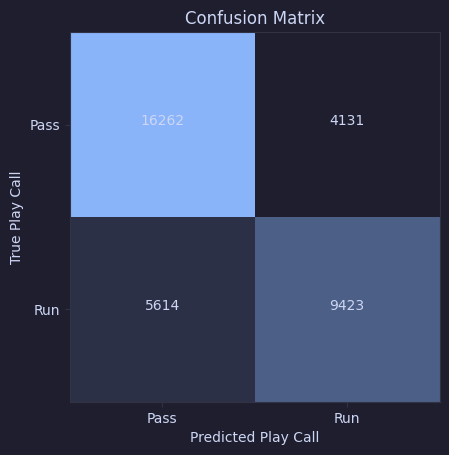

In [18]:
nflpp.plot_confusion_matrix(test_target, test_preds)

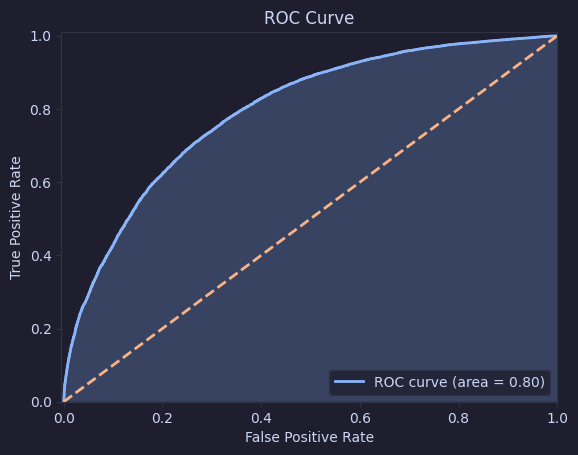

In [19]:
probabilities = model.predict(dtest)
nflpp.plot_roc_curve(test_target, probabilities)

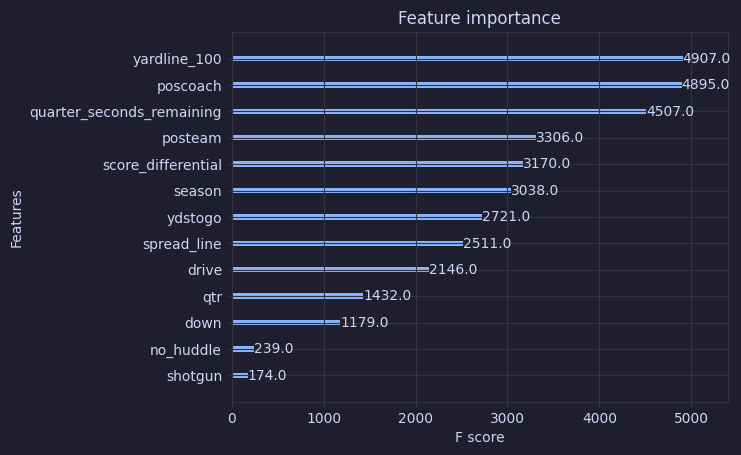

In [20]:
features = train_data.drop("play_type", axis=1).columns.tolist()
model.feature_names = features
xgb.plot_importance(model)
plt.show()

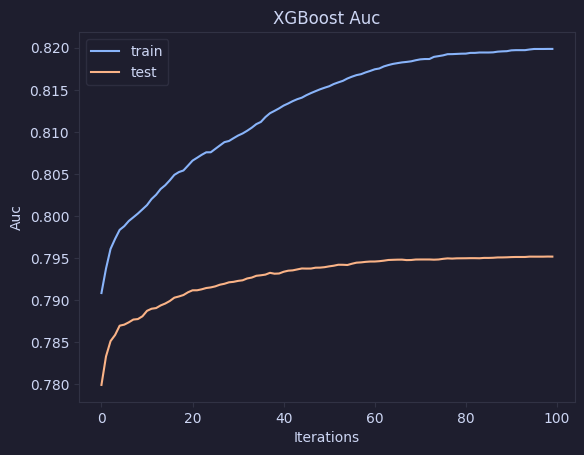

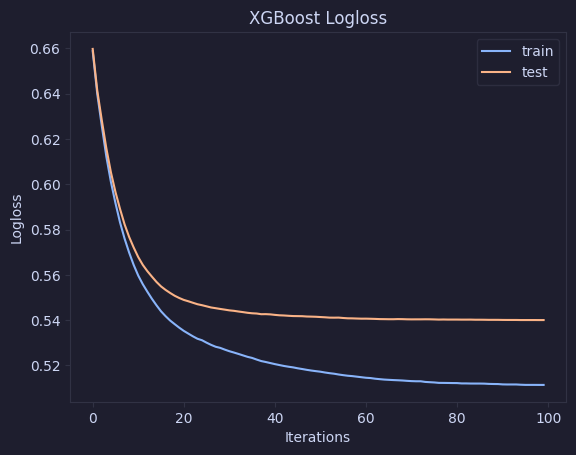

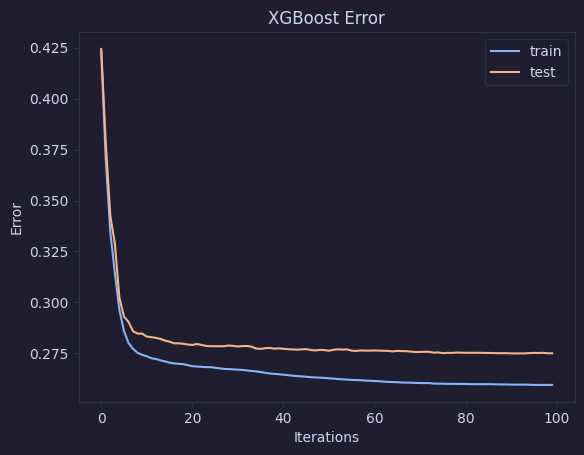

In [21]:
nflpp.plot_learning_curves(eval_results)